In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline

Using TensorFlow backend.
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/trentonbricken/anacond

In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
import sys
sys.path.insert(1, '/Users/trentonbricken/protein-generators/deep_boltzmann/deep_boltzmann')

In [4]:
pwd

'/Users/trentonbricken/protein-generators/notebooks'

In [5]:
from PlottingFunctions import *

In [6]:
rcParams.update({'font.size': 16})

In [7]:
#%load_ext autoreload
#%autoreload 2

In [8]:
import os
os.chdir('../deep_boltzmann')

In [9]:
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [10]:
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import softmax

AA_num=20 # ignoring spaces here. 

In [11]:
from EVCouplingsGen import *

## Importing the EVCouplings model

I need to find a way to make this tensorflow friendly

In [12]:
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

In [13]:
pwd

'/Users/trentonbricken/protein-generators/deep_boltzmann'

In [14]:

focus_seqs = read_fa('deep_boltzmann/EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('deep_boltzmann/EVCouplingsStuff/DYR.model')
scores = evc_model.hamiltonians(list(focus_seqs['seq']))
        

In [15]:
evc_model.alphabet_map

{'A': 0,
 'C': 1,
 'D': 2,
 'E': 3,
 'F': 4,
 'G': 5,
 'H': 6,
 'I': 7,
 'K': 8,
 'L': 9,
 'M': 10,
 'N': 11,
 'P': 12,
 'Q': 13,
 'R': 14,
 'S': 15,
 'T': 16,
 'V': 17,
 'W': 18,
 'Y': 19}

In [16]:
focus_seqs.head()

,header,seq,seq_ID,species
0,DYR_ECOLI/1-159,SLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHTWE...,DYR_ECOLI/1-159,None
1,UniRef100_R7UK12/6-185,NLVVAACTNKGIGVDGRLPWTIRGDMAFFRKITSENVVLMGRKTWE...,UniRef100_R7UK12/6-185,None
2,UniRef100_T1G9P0/5-182,QIIVALCKNRGIGLNNSIPWKLPGDMTFFRKLTSENAILMGRKTWD...,UniRef100_T1G9P0/5-182,None
3,UniRef100_UPI0009BA7A0F/1-159,SLMWAMDENGVIGKDNQLPWHLPEDLKFFKRTTMGRPIVMGRKTWD...,UniRef100_UPI0009BA7A0F/1-159,None
4,UniRef100_UPI0002897BAD/1-159,SFIFAMDANRLIGKDNDLPWHLPNDLAYFKKVTSGHSIIMGRKTYE...,UniRef100_UPI0002897BAD/1-159,None


In [17]:
enc_seqs=[]
for seq in focus_seqs['seq']:
    enc_seqs.append(encode_aa(seq, evc_model.alphabet_map)) 

enc_seqs = np.asarray(enc_seqs)
target_seq = enc_seqs[0]#encode_aa(np.char.upper(ali.matrix[0, :]), a2n)

oh = []
oh_flat = []
N=20 # none of these focus have gaps, else should be 21. 
for seq in enc_seqs:
    o = onehot(seq,N)
    oh.append(o)
    oh_flat.append(o.flatten())
oh=np.asarray(oh)
oh_flat=np.asarray(oh_flat)
print('calculating weights and identities')
N = oh.shape[0]
L = oh.shape[1]
AA = oh.shape[2]
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)
oh.shape


calculating weights and identities


(7848, 155, 20)

In [18]:
enc_seqs.shape

(7848, 155)

In [19]:
h = evc_model.h_i
h.shape

(155, 20)

In [20]:
t_oh = oh[0]
t_oh.shape

(155, 20)

In [21]:
t_oh_flat =t_oh.flatten()
t_oh_flat.shape

(3100,)

In [22]:
t_oh_flat.shape

(3100,)

In [23]:
import torch

In [24]:
A = deepcopy(evc_model.J_ij)

In [25]:
A.shape

(155, 155, 20, 20)

In [26]:
B = A.transpose(0,2,1,3)
C = B.reshape(155*20,155*20)
print(C.shape)
J = torch.Tensor(C)

(3100, 3100)


In [27]:
batch_aa_seqs = focus_seqs.loc[0:5, 'seq']
batch_aa_seqs = np.asarray(batch_aa_seqs)
batch_aa_seqs.shape

(6,)

In [28]:
batch_oh_flat = torch.Tensor(oh_flat[0:5,:])
batch_oh_flat.shape

torch.Size([5, 3100])

In [29]:
for aa in batch_aa_seqs:
    print( evc_model.hamiltonians([aa]) )

[[691.78837246 164.79214785 526.99622461]]
[[616.32432526 146.38899448 469.93533077]]
[[609.8757413 137.3846627 472.4910786]]
[[675.83674874 124.9098807  550.92686803]]
[[668.12467203 117.67201034 550.45266169]]
[[667.23208667 116.96387957 550.2682071 ]]


In [30]:
J.shape

torch.Size([3100, 3100])

In [31]:
h_flat = torch.Tensor(h).flatten()
h_flat.shape

torch.Size([3100])

In [32]:
# got the h component
torch.matmul(batch_oh_flat, h_flat )

tensor([526.9962, 469.9354, 472.4911, 550.9269, 550.4527])

In [33]:
# batch oh flat must be of dimension: batch x (AA*len). J must be (AA*len)x(AA*len) and ensure that it is reshaped in the right way! (check diagonal is all zeros)
((batch_oh_flat * (torch.matmul(batch_oh_flat, J))).sum(-1) /2) + torch.matmul(batch_oh_flat, h_flat )

tensor([691.7883, 616.3243, 609.8757, 675.8368, 668.1247])

## now seeing if this works for a softmax!! 

In [146]:

shape = (3,2,20)
m = torch.distributions.Dirichlet(torch.tensor(np.ones(shape)*0.5), 5)
sm = m.sample()

In [147]:
sm = sm.reshape(shape[0], shape[1]*shape[2])
sm.shape

torch.Size([3, 40])

In [148]:
sm.sum(-1)

tensor([2.0000, 2.0000, 2.0000], dtype=torch.float64)

In [193]:
J_test = torch.Tensor(np.random.normal(10,10,(2,20,2,20))).double()
J_test = ( J_test + J_test.transpose(0, 2).transpose(1,3) ) /2
J_test[torch.arange(J_test.shape[0]),:,torch.arange(J_test.shape[0]),:] = 0
J_test = J_test.reshape(2*20, 2*20)
J_test.shape

torch.Size([40, 40])

In [194]:
J_test == J_test.T

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [195]:
J_test[0,-1] 

tensor(8.5259, dtype=torch.float64)

In [196]:
J_test[-1,0]

tensor(8.5259, dtype=torch.float64)

In [197]:
h_test = torch.Tensor(np.random.normal(5,10,(40))).double()
h_test.shape

torch.Size([40])

In [198]:
def mat_evh(data):
    data=data.double()
    #print(torch.matmul(data, J_test))
    return ((data * (torch.matmul(data, J_test))).sum(-1) /2) + torch.matmul(data, h_test )

In [199]:
print(xJx_batch.shape, (xJx_batch != 0).sum(), xJx_batch.sum())

torch.Size([3, 40, 40]) tensor(2400) tensor(59.2231, dtype=torch.float64)


In [216]:
# getting the true values by calculating each one. 
I = np.eye(20)
for ind in range(3):
    oh_sm = sm[ind,:].reshape(2,20) #.softmax(-1)
    s = 0
    sum_of_probs=0
    for i in range(20):
        for j in range(20):
            to_test = torch.Tensor(np.hstack([I[i,:], I[j,:]]) )
            sum_of_probs += (oh_sm[0,i]*oh_sm[1,j])
            v = mat_evh(to_test)
            s += v * (oh_sm[0,i]*oh_sm[1,j]) # val x prob of it being drawn. 
    print('ind:',ind, 'value', s)

ind: 0 value tensor(26.3505, dtype=torch.float64)
ind: 1 value tensor(26.8892, dtype=torch.float64)
ind: 2 value tensor(19.0263, dtype=torch.float64)


In [201]:
sm.shape

torch.Size([3, 40])

In [202]:
oh_sm.shape

torch.Size([2, 20])

In [203]:
sum_of_probs

tensor(1.0000, dtype=torch.float64)

In [221]:
x_batch = deepcopy(sm)
xJ_batch = torch.einsum('nl,lk->nlk', x_batch, J_test)
# transpose all but the batch! 
# at this point it is no longer symmetric. 
xJx_batch = torch.einsum('nl,nlk->nlk', x_batch, xJ_batch.transpose(-1, -2))
o = xJx_batch.sum(axis=(-1,-2))/2 + torch.einsum('nl,l->n', x_batch, h_test)
o

tensor([26.3505, 26.8892, 19.0263], dtype=torch.float64)

In [222]:
mat_evh(x_batch)

tensor([26.3505, 26.8892, 19.0263], dtype=torch.float64)

In [223]:
J_test == J_test.T

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [224]:
J_test[5,39]

tensor(26.3260, dtype=torch.float64)

In [225]:
J_test[39,5]

tensor(26.3260, dtype=torch.float64)

In [226]:
xJ_batch[0,5,30] #== xJ_batch.transpose(-1, -2)[0,:,:]

tensor(2.3954, dtype=torch.float64)

In [227]:
xJ_batch.transpose(-1, -2)[0,-5,-30]

tensor(0.0346, dtype=torch.float64)

In [228]:
torch.Tensor(np.array([[1,2],[3,4]])).T

tensor([[1., 3.],
        [2., 4.]])

In [229]:
torch.Tensor(np.array([[1,2],[3,4]])).transpose(-1, -2)

tensor([[1., 3.],
        [2., 4.]])

In [230]:
x_batch = deepcopy(sm[0])
(x_batch.T@J_test@x_batch).sum()/2 + torch.matmul(x_batch, h_test)

tensor(26.3505, dtype=torch.float64)

In [231]:
xJ_batch.shape

torch.Size([3, 40, 40])

In [232]:
xJ_batch = torch.einsum('l,lk->lk', x_batch, J_test)
xJx_batch = torch.einsum('l,lk->lk', x_batch, xJ_batch.T)
o = xJx_batch.sum(axis=(-1,-2))/2 +  x_batch@h_test
o

tensor(26.3505, dtype=torch.float64)

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [55]:
x_batch.shape

torch.Size([40])

In [60]:
(x_batch.T*torch.eye(40).double()*torch.ones((40,1)).double()).sum()

tensor(2., dtype=torch.float64)

In [ ]:
NLL = torch.matmul(x,Jsym) # broadcasting. THIS IS FOR ANY AA a AT POSITION p WHAT THE MATCHING SEQUENCE CONVERSION PENALTY/BONUS IS. 
        # PAIRWISE WITH EVERYTHING ELSE IN THE WHOLE SEQUENCE. EVEN IF THE THING ISNT THERE. PAIRWISE INTERACTION WITH WHAT IS THERE. 
        # ADD H TO EVERYTHING EVEN IF IT ISNT PRESENT THERE. 
        # *** BASICALLY WHAT SHOULD BE THERE GIVEN ALL OF THE OTHER INTERACTIONS AND THE SINGLETON VALUE THAT IS THERE??? 
        NLL = NLL.view(batch_size,L,AA).log_softmax(-1).view(batch_size,L*AA) #CONVERT TO SOFTMAXES.
        # SOFTMAX IS TRYING TO PREDICT AT EACH POSITION WHAT THE AMNO ACID IS. 

        # weights include in batch draw frequency- to include would be w[batch]*x
        NLL = -((x_one_hot_mask*NLL).sum(-1)).sum()

to dos. Get this working for a batch of sequences and have it work for a weighted sequence too. 

tensor(164.7921)


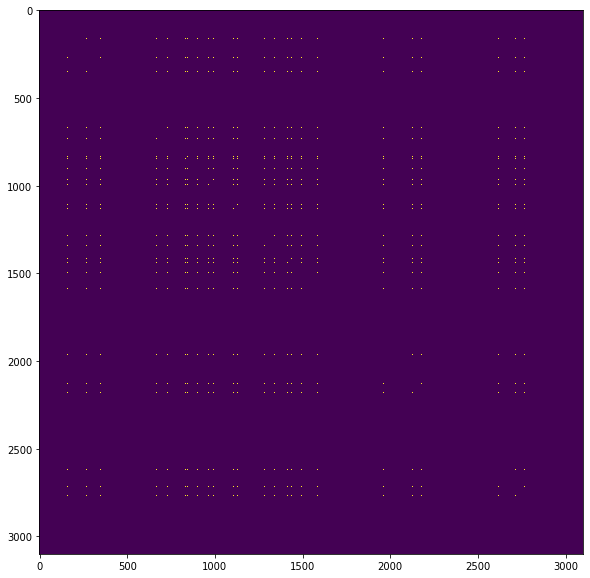

In [197]:
%matplotlib inline
J = torch.Tensor(C)
plt.imshow(((flat_tens*J).T*(flat_tens) != 0))
plt.gcf().set_size_inches(10,10)
print(((flat_tens*J).T*(flat_tens)).sum()/2)